In [2]:
import matplotlib
matplotlib.use('NbAgg')
from matplotlib import pyplot as plt
from matplotlib.widgets import Button
import numpy as np
from skimage.io import imread
import sys
sys.path.append(r'C:\Users\AhrensLab\Documents\GitHub\dmd')
from dmd.gui import DraggableRectangle, RoiDrawing
plt.ion()

In [4]:
calibration_image_fname = r'Z:\davis\data\dmd_calibration\20170527\checkerboard.png'
calibration_image = imread(calibration_image_fname)

<IPython.core.display.Javascript object>


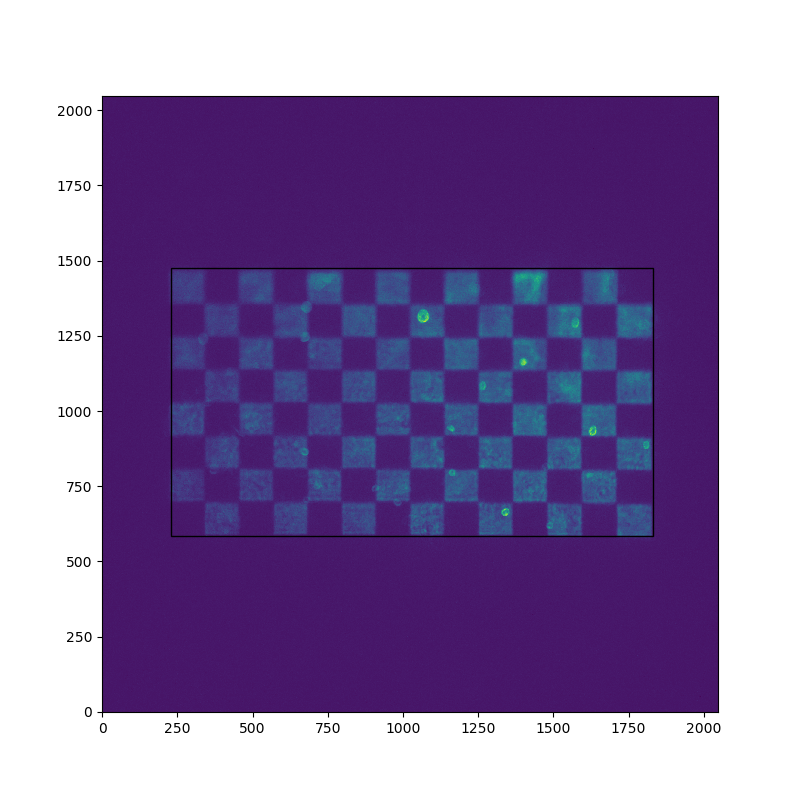

In [125]:
from matplotlib.patches import Rectangle
fig, axs = plt.subplots(figsize=(8,8))
axs.imshow(calibration_image, origin='lower')
x_guess, y_guess, w_guess, h_guess = 230, 588, 1600, 874
rect = Rectangle((x_guess,y_guess), w_guess, h_guess, fill=False)
axs.add_patch(rect)
dr = DraggableRectangle(rect)
dr.connect()
plt.show()

In [126]:
x, y, w, h = dr.rect.get_x(), dr.rect.get_y(), dr.rect.get_width(), dr.rect.get_height()
dmd_rect = [int(x), int(y), int(x + w), int(h + y)]
print(x,y,w,h)

230.0 578.025974026 1600.0 897.272727273


<IPython.core.display.Javascript object>


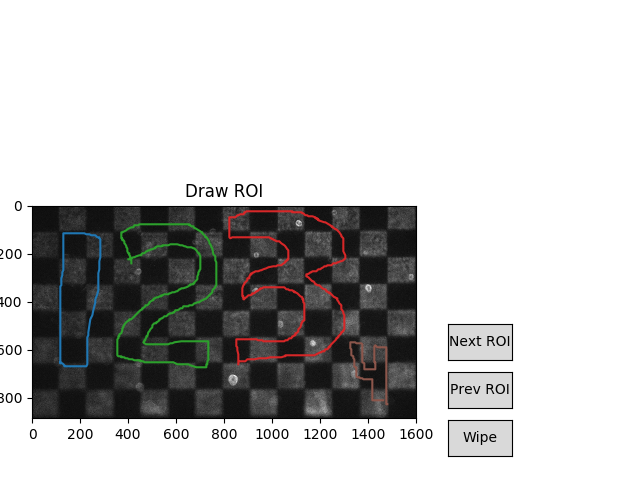

In [53]:
sample_image_fname = calibration_image_fname
sample_image = imread(sample_image_fname)

data = sample_image[dmd_rect[1]:dmd_rect[3],dmd_rect[0]:dmd_rect[2]]

fig = plt.figure()
ax = plt.axes([.05, .05, .6, .6])
ax.set_title('Draw ROI')
ax.imshow(data, cmap='gray')
#
roi_draw = RoiDrawing(ax, data)

ax_butt = plt.axes([0.7, 0.05, 0.1, 0.075])
wipe_butt = Button(ax_butt, 'Wipe')
wipe_butt.on_clicked(roi_draw.wipe)

ax_decr = plt.axes([.7, .15, .1, .075])
decr_button = Button(ax_decr, 'Prev ROI')
decr_button.on_clicked(roi_draw.focus_decr)

ax_incr = plt.axes([.7, .25, .1, .075])
incr_button = Button(ax_incr, 'Next ROI')
incr_button.on_clicked(roi_draw.focus_incr)
plt.show()

<IPython.core.display.Javascript object>


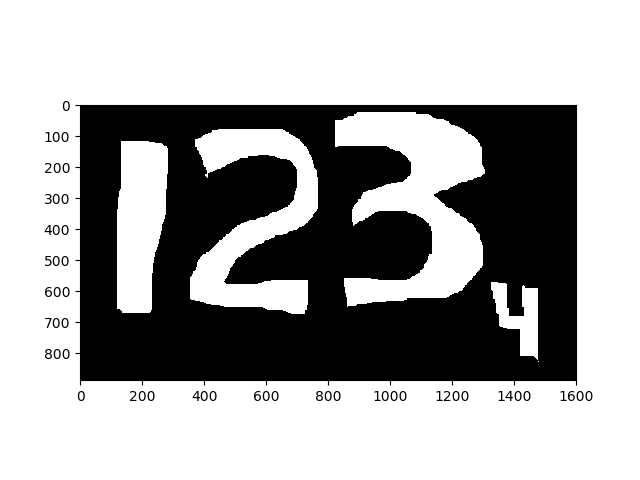

In [54]:
fig, axs = plt.subplots()
masks = np.array([r.get_mask() for r in roi_draw.rois if len(r.x) > 0])
plt.imshow(masks.sum(0), cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


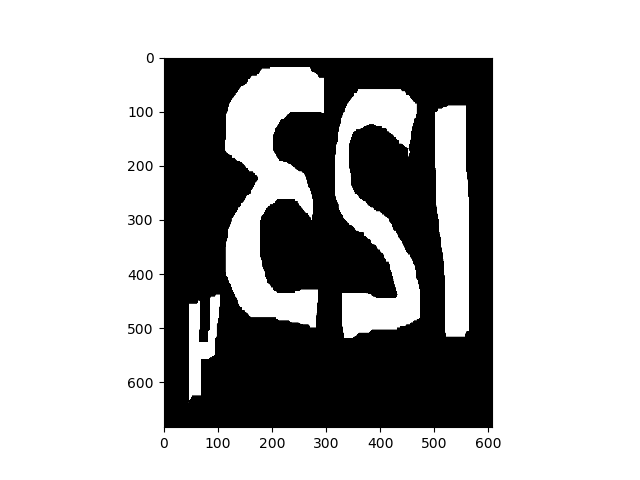

In [64]:
# Apply transformations to ROI images and save to disk
from skimage.transform import resize
masks_resized = np.array([resize(m, output_shape = dmd_dims, mode='constant', cval=0) for m in masks])
# need to flip along x axis
masks_resized = masks_resized[:,:,::-1]
fig, axs = plt.subplots()
dmd_dims = (684,608)
plt.imshow(masks_resized.sum(0),cmap='gray')
plt.show()

In [58]:
from skimage.io import imsave
out_path = 'C:/Users/AhrensLab/Documents/GitHub/BehaveAndScanOP/StimAndSwim/background_images/'
for ind, m in enumerate(masks_resized):
    imsave(out_path + 'pattern_{:04d}.png'.format(ind), m)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


# Compare projected patterns with programmed patterns

In [79]:
# Load images of dmd-rendered ROI from disk
from glob import glob
rois_fl = np.array([imread(f) for f in glob('Z:/davis/data/dmd_calibration/20170527/roi*.png')])
masks_full = np.zeros([masks.shape[0], *calibration_image.shape])
masks_full[:, dmd_rect[1]:dmd_rect[3],dmd_rect[0]:dmd_rect[2]] = masks

<IPython.core.display.Javascript object>


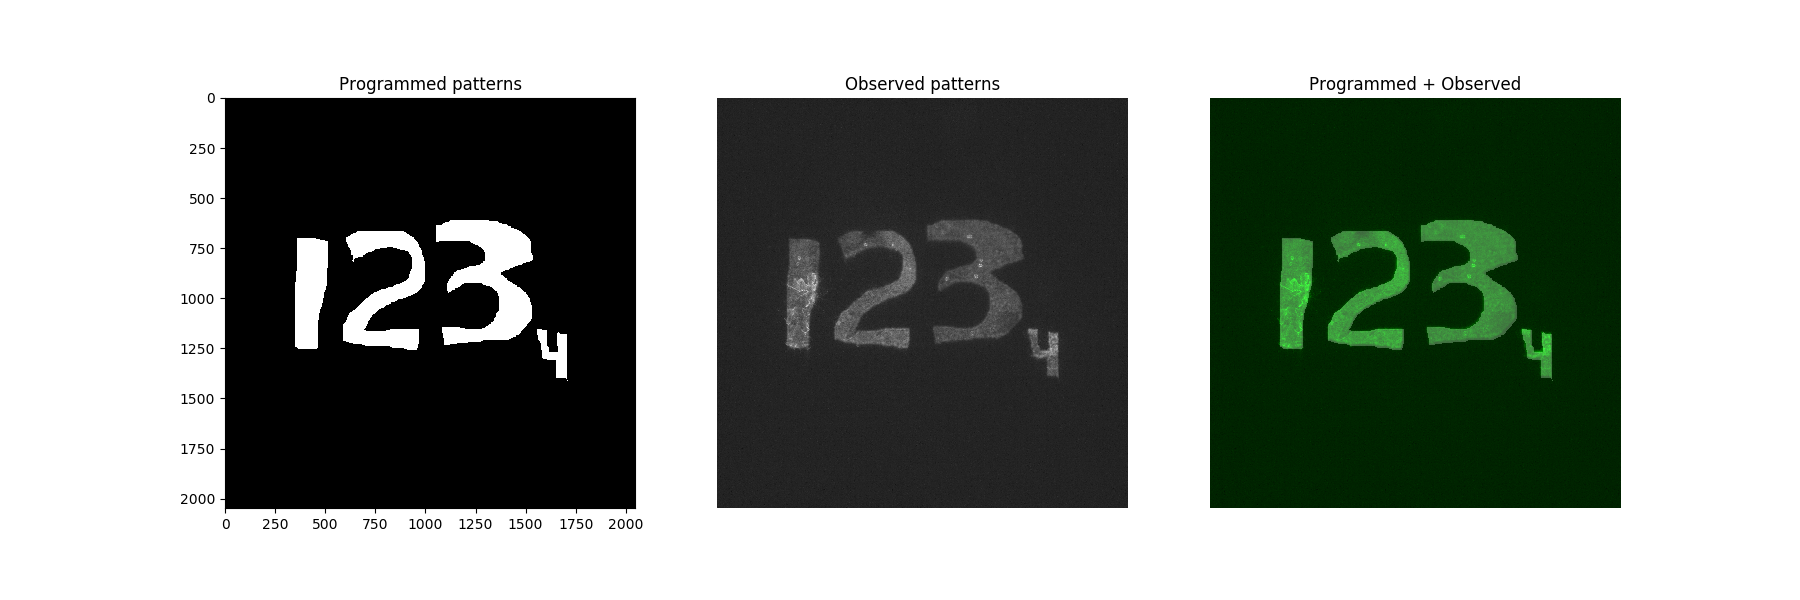

In [141]:
from skimage.exposure import rescale_intensity
img0 = np.zeros(shape=(masks_full.shape[1:]) + (3,), dtype=np.uint8)
rescaled_masks = rescale_intensity(masks_full.sum(0), out_range=(0,255))
rescaled_rois_fl = rescale_intensity(rois_fl.sum(0) ** .5, out_range=(0,255))
img0[:,:,0] = rescaled_masks // 4
img0[:,:,1] = (rescaled_rois_fl + rescaled_masks // 4).clip(0,255)
img0[:,:,2] = rescaled_masks // 4

fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(18,6))
from scipy.stats import zscore

axs[0].imshow(masks_full.sum(0), cmap='gray')
axs[0].title.set_text('Programmed patterns')

axs[1].imshow(rois_fl.sum(0) ** .5, cmap='gray')
axs[1].title.set_text('Observed patterns')
axs[1].axis('off')
#axs[2].imshow(zscore(masks_full.sum(0), axis=None) - zscore(rois_fl.sum(0), axis=None), cmap='gray')
axs[2].imshow(img0)
axs[2].set_title('Programmed + Observed')
axs[2].axis('off')
plt.show()